# Import Libraries

In [14]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
import matplotlib.pyplot as plt
from random import shuffle
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
# setting random seed so that initial value of random variable will be the same
from numpy.random import seed
seed(42)

In [4]:
class_dic = {"A":0,"B":1,"C":2, "D":3, "E":4, "n":5}

In [5]:
# data can be downloaded from https://www.kaggle.com/grassknoted/asl-alphabet. In this example, only 6 classes from 
# training folder have been used. We can test for all classes

In [6]:
# path of the data
files = os.listdir('asl_data_6_classes/')
for i in range(10):
    shuffle(files)

# read image and create train, validation and test set

In [7]:
class_count = {'A':0,'B':0,'C':0, 'D':0,'E':0,'n':0}
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []
unique_list=[]

for file_name in files:
    label = file_name[0]
    unique_list.append(label)
    path = 'asl_data_6_classes/'+file_name
    image = cv2.imread(path)
    resized_image = cv2.resize(image,(224,224))
    if class_count[label]<2500:
        class_count[label]+=1
        X_train.append(resized_image)
        Y_train.append(class_dic[label])
    elif class_count[label]>=2500 and class_count[label]<2750:
        class_count[label]+=1
        X_val.append(resized_image)
        Y_val.append(class_dic[label])
    else:
        X_test.append(resized_image)
        Y_test.append(class_dic[label])

# convert list of data into nd array

In [8]:
np.save('np_array_asl_data/train_set.npy',X_train)
np.save('np_array_asl_data/train_classes.npy',Y_train)

np.save('np_array_asl_data/validation_set.npy',X_val)
np.save('np_array_asl_data/validation_classes.npy',Y_val)

np.save('np_array_asl_data/test_set.npy',X_test)
np.save('np_array_asl_data/test_classes.npy',Y_test)

X_train=np.load('np_array_asl_data/train_set.npy')
Y_train=np.load('np_array_asl_data/train_classes.npy')

X_valid=np.load('np_array_asl_data/validation_set.npy')
Y_valid=np.load('np_array_asl_data/validation_classes.npy')

X_test=np.load('np_array_asl_data/test_set.npy')
Y_test=np.load('np_array_asl_data/test_classes.npy')

In [9]:
print("Total no. of data points: {shape}".format(shape=len(unique_list)))

# dimensions of training data
print("dimensions of training data: {shape}".format(shape=X_train.shape))
print("dimensions of training label: {shape}".format(shape=Y_train.shape))

# dimensions of test data
print("dimensions of test data: {shape}".format(shape=X_test.shape))
print("dimensions of test label: {shape}".format(shape=Y_test.shape))

# dimensions of validation data
print("dimensions of validation data: {shape}".format(shape=X_valid.shape))
print("dimensions of validation label: {shape}".format(shape=Y_valid.shape))


Total no. of data points: 18000
dimensions of training data: (15000, 224, 224, 3)
dimensions of training label: (15000,)
dimensions of test data: (1500, 224, 224, 3)
dimensions of test label: (1500,)
dimensions of validation data: (1500, 224, 224, 3)
dimensions of validation label: (1500,)


In [15]:
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)
Y_test = np_utils.to_categorical(Y_test)

In [16]:
class_list = ['A', 'B', 'C', 'D', 'E', 'n']

In [17]:
def image_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [18]:
def display_images(data, title, display_label = True):
    x, y = data
    fig, axes = plt.subplots(2, 6, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i])
        if display_label:
            ax.set_xlabel(class_list[list(y[i]).index(1)])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

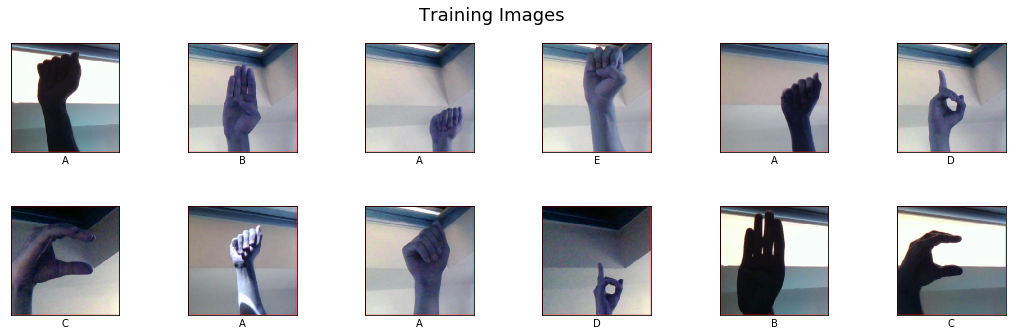

In [20]:
display_images(image_batch(12, X_train, Y_train), 'Training Images')

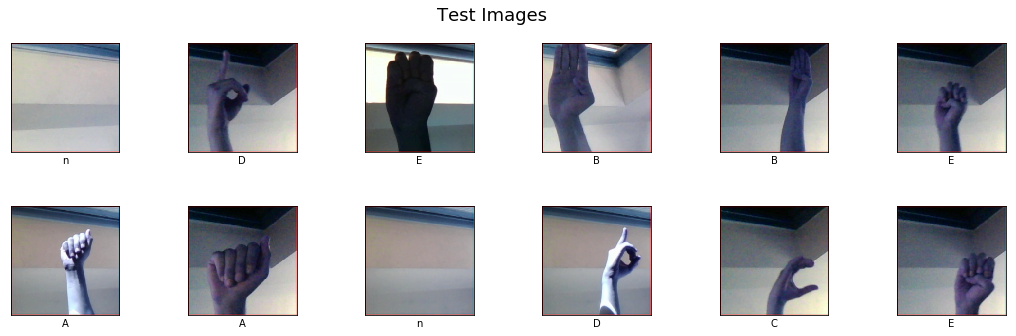

In [38]:
display_images(image_batch(12, X_test, Y_test), 'Test Images')

In [23]:
model = Sequential()

#Conv Layer 1, The 1st convolutional layer filters the 224×224×3 input image with 96 kernels of size 11×11×3 with a stride of 
# 4 pixles
model.add(Conv2D(filters=96, input_shape=(224, 224, 3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Conv Layer 2, The 2nd convolutional layer takes as input the output of the 1st convolutional layer and filters it 
# with 256 kernels of size 5 × 5 × 48
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
# we can also add batch normalization steps here. To make more changes, we can set padding='same'
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# The 3rd, 4th and 5th layers are convolutional layers with filter size 3×3 and a stride of 1 pixel. These layers layers are 
# connected to one another without any intervening pooling or normalization layers. The first two used 384 
# filters where the third used 256 filters

# Conv Layer 3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# Conv Layer 4
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# Conv Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# flatten the architecture for fully Connected layer

model.add(Flatten())

# 1st Fully Connected Layer
# model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Dense(4096))
model.add(Activation('relu'))

# Dropout layer, we can change the value 0.4 as experiments to see the different result

model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))

# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(6))
model.add(Activation('softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 384)        

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6), loss=tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [26]:
epochs = 4
batch_size = 64

In [27]:
train_model = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), shuffle=True)

Train on 15000 samples, validate on 1500 samples
Epoch 1/4
15000/15000 [==============================] - 531s 35ms/sample - loss: 0.9235 - acc: 0.6224 - val_loss: 0.1680 - val_acc: 0.9373
Epoch 2/4
15000/15000 [==============================] - 537s 36ms/sample - loss: 0.1267 - acc: 0.9559 - val_loss: 0.2315 - val_acc: 0.9320
Epoch 3/4
15000/15000 [==============================] - 579s 39ms/sample - loss: 0.0382 - acc: 0.9895 - val_loss: 0.0057 - val_acc: 0.9980
Epoch 4/4
15000/15000 [==============================] - 546s 36ms/sample - loss: 0.0664 - acc: 0.9811 - val_loss: 0.0169 - val_acc: 0.9973


In [28]:
print(train_model.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


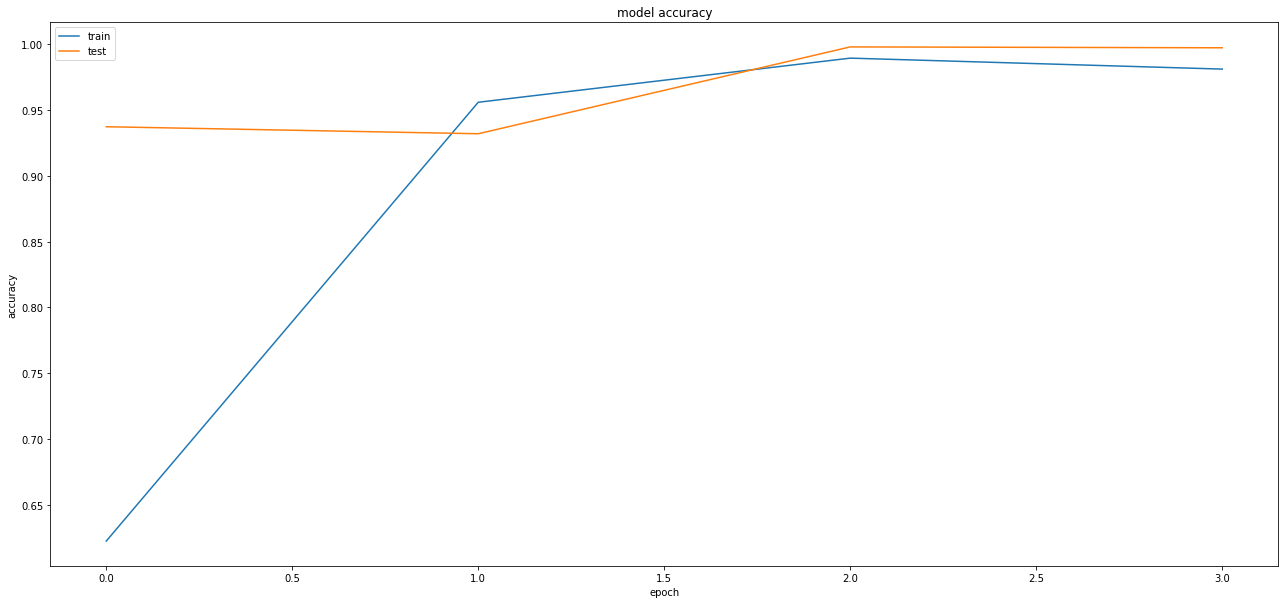

In [30]:
plt.figure(figsize=(22, 10))
plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim((0.9,.94))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

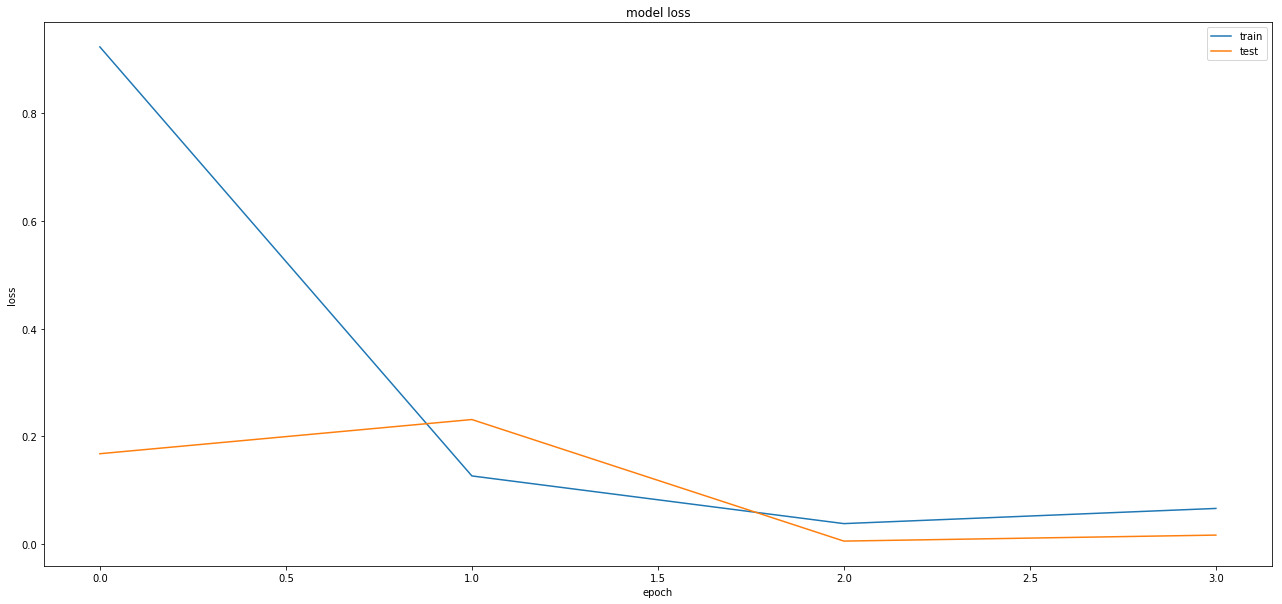

In [31]:
plt.figure(figsize=(22, 10))
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim((0,.3))
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
def create_trace(x,y,ylabel,color):
    trace = go.Scatter(
        x = x,y = y,
        name=ylabel,
        marker=dict(color=color),
        mode = "markers+lines",
        text=x
    )
    return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')


In [33]:
plot_accuracy_and_loss(train_model)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [34]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
y_true = Y_test

In [36]:
p = predicted_classes
y = np.argmax(y_true, axis=1)
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [37]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 1497
Incorrect predicted classes: 3


In [39]:
target_names = ["Class {} ({}) :".format(i,class_list[i]) for i in range(6)]
print(classification_report(y, predicted_classes, target_names=target_names))

               precision    recall  f1-score   support

Class 0 (A) :       1.00      0.99      1.00       250
Class 1 (B) :       1.00      1.00      1.00       250
Class 2 (C) :       1.00      1.00      1.00       250
Class 3 (D) :       1.00      1.00      1.00       250
Class 4 (E) :       0.99      1.00      0.99       250
Class 5 (n) :       1.00      1.00      1.00       250

  avg / total       1.00      1.00      1.00      1500



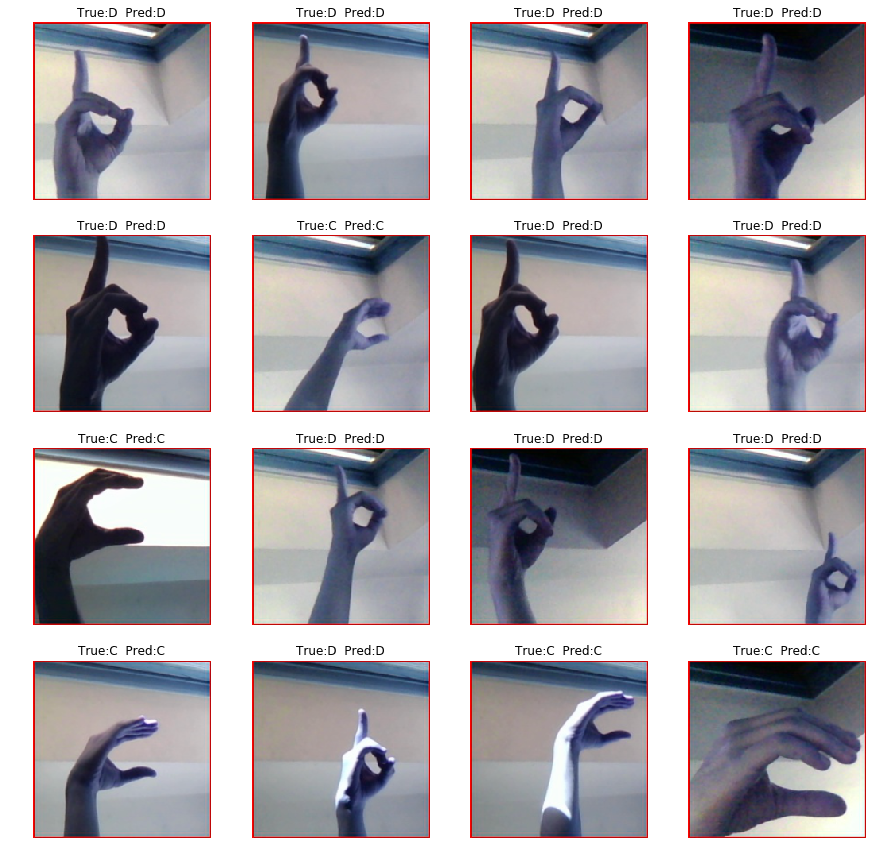

In [59]:
def plot_images(data_index, n, nrows, ncols):
    f, ax = plt.subplots(nrows,ncols, figsize=(15,15))

    for i, indx in enumerate(data_index[:n]):
        ax[i//4, i%4].imshow(X_test[indx])
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(class_list[y[indx]], class_list[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, 16, 4, 4)

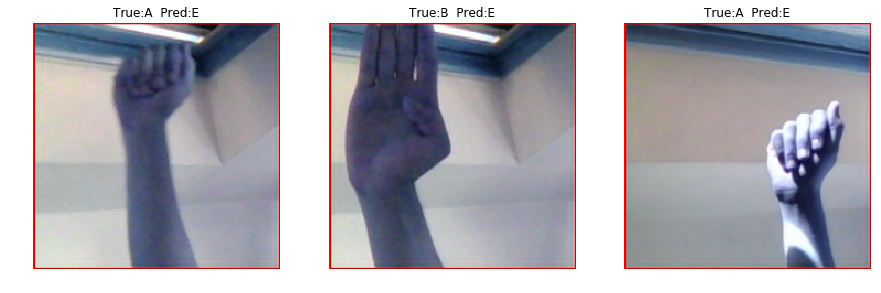

In [84]:
f, ax = plt.subplots(1,3, figsize=(15,15))
for i, indx in enumerate(incorrect):
    ax[i].imshow(X_test[indx])
    ax[i].axis('off')
    ax[i].set_title("True:{}  Pred:{}".format(class_list[y[indx]], class_list[predicted_classes[indx]]))
plt.show()